In [1]:
from elm import ELM, ENRELM, approximated_ENRELM, incremental_ENRELM
import numpy as np
import os
from sklearn.model_selection import train_test_split
import utils
from matplotlib import pyplot as plt
import time
import logger
import datagenerator
import dataloader
import pandas as pd

# Utils

In [2]:
def syntetic_dataset_simulation(dataset_index):
    filename = f'dataset_{dataset_index}.csv'
    file_path = os.path.join('datasets/synthetic', filename)
    # Load the dataset from the CSV file
    dataset = np.loadtxt(file_path, delimiter=',')

    # Split the dataset into X and y
    X = dataset[:, :-1]
    y = (dataset[:, -1]).reshape(-1,1)

    assert(y.shape == (X.shape[0],1))
    return single_dataset_simulation(X,y)


def looped_ELM(X_train, X_test, y_train, y_test, loops = 20):
    hidden_space_dim = int(np.minimum(50 * X_train.shape[1], round(X_train.shape[0] * 0.5)))
    test = {
        'X': X_test,
        'y': y_test
    }

    loops = 20
    loops_train_err_ELM = np.zeros(shape=(loops,hidden_space_dim))
    loops_test_err_ELM = np.zeros(shape=(loops,hidden_space_dim))

    total_timing = 0                                                                            

    for loop in range(loops):
        for n in range(1,hidden_space_dim+1):
            _, _, results = ELM(n, -1, X_train, y_train, test)
            loops_train_err_ELM[loop, n-1] = results['training_error']
            loops_test_err_ELM[loop, n-1] = results['test_error']
            total_timing += results['timing']

                                                                          

    mean_loop_timing = total_timing / loops

    training_error = np.mean(loops_train_err_ELM, axis = 0)

    test_error = np.mean(loops_test_err_ELM, axis = 0)

    data = {
        'training_error': training_error,
        'test_error': test_error,
        'total_timing': total_timing,
        'mean_loop_timing': mean_loop_timing
        }

    return data



def single_dataset_simulation(X,y):
    seed_train_test_split = 1234

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
    X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)
    
    test = {
        'X': X_test,
        'y': y_test
    }

    # approximated ENR-ELM
    _, _, results_approximated_ENRELM = approximated_ENRELM(X_train, y_train, sort_by_correlation=True, threshold=1.0, test=test)  

    # incremental ENR-ELM
    _, _, _, results_incremental_ENRELM = incremental_ENRELM(X_train, y_train, threshold=1e-5, test = test)

    #ELM
    results_ELM = looped_ELM(X_train, X_test, y_train, y_test, loops = 20)
    
    results = [results_approximated_ENRELM, results_incremental_ENRELM, results_ELM]
    suffixes = ["_approximated_ENRELM", "_incremental_ENRELM", "_ELM"]

    data = {}
    for result, suffix in zip(results, suffixes):
        for key, value in result.items():
            data[key + suffix] = value


    return data

In [9]:
import pandas as pd
def filter_csv(file_path, n0=None, X_distribution=None, X_range=None, 
               X_cov=None, X_rho=None, y_function=None, y_terms=None, y_SNR=None):
    # Read the CSV file
    df = pd.read_csv(file_path, sep=';')  # Assuming ';' is the delimiter 
    
    # Applying filters based on provided parameters
    filters = {
        'T': 300,
        'n0': n0,
        'X_distribution': X_distribution,
        'X_range': X_range,
        'X_cov': X_cov,
        'X_rho': X_rho,
        'y_function': y_function,
        'y_terms': y_terms,
        'y_SNR': y_SNR
    }
    
    # Remove None values from filters
    filters = {key: value for key, value in filters.items() if value is not None}
    #print(filters)
    # Filter the DataFrame
    for column, value in filters.items():
        #print(column + "\t\t" + str(value))
        df = df[df[column] == value]

    if len(df['index'].tolist()) > 1:
        logger.error("Found more than one synthetic dataset matching filter, unable to identify a single dataset")
    elif len(df['index'].tolist()) == 0:
        logger.error("Found 0 synthetic dataset matching filter")

    # Return the index of the filtered rows
    return df['index'].tolist()


def write_times_csv(filename, df_times):
    # Check if the file exists
    df_times.to_csv(filename, sep=";", index=False)
    #if not os.path.isfile(filename):
        # File does not exist, save df_times as is
    #    df_times.to_csv(filename, sep=";", index=False)
    #else:
        # File exists, load the old dataframe
    #    old_df_times = pd.read_csv(filename, sep=";")
        
        # Read the value from the "istances" column
    #    instances = old_df_times['istances'].iloc[0]  # All rows contain the same value

        # Update the values in df_times
      
    #    df_times['istances'] = instances + 1
    #    print(old_df_times['time_ENRELM'])
    #    df_times['time_ENRELM'] = old_df_times['time_ENRELM'] + (df_times['time_ENRELM'] - old_df_times['time_ENRELM']) / df_times['istances']
    #    df_times['time_ELM'] = old_df_times['time_ELM'] + (df_times['time_ELM'] - old_df_times['time_ELM']) / df_times['istances']
    #    df_times['time_ELM_per_loop'] = old_df_times['time_ELM_per_loop'] + (df_times['time_ELM_per_loop'] - old_df_times['time_ELM_per_loop']) / df_times['istances']

        # Save the updated dataframe to the file
     #   df_times.to_csv(filename, sep=";", index=False)

# Experiments on synthetic datasets

Execution synthetic dataset with index: 1


C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\3583394673.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


Execution synthetic dataset with index: 2
Execution synthetic dataset with index: 3
Execution synthetic dataset with index: 4
Execution synthetic dataset with index: 5
Execution synthetic dataset with index: 6
Execution synthetic dataset with index: 7
Execution synthetic dataset with index: 8
Execution synthetic dataset with index: 9
Execution synthetic dataset with index: 10
Execution synthetic dataset with index: 11
Execution synthetic dataset with index: 12


INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


   dataset  total_timing_ELM  mean_loop_timing_ELM  \
0        1         6254.1214            312.706070   
1        2         4072.1366            203.606830   
2        3         4713.8499            235.692495   
3        4         3668.9643            183.448215   
4        5         3731.8152            186.590760   
5        6         4637.0522            231.852610   
6        7         5948.7098            297.435490   
7        8         4876.8912            243.844560   
8        9         3727.2569            186.362845   
9       10         4632.4012            231.620060   
10      11         3724.3691            186.218455   
11      12         3775.2081            188.760405   

    timing_approximated_ENRELM  timing_incremental_ENRELM  
0                      17.9488                   211.4183  
1                      15.9257                   202.4591  
2                      14.9608                   176.3366  
3                      14.9535                   198.4681

INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\3583394673.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\3583394673.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


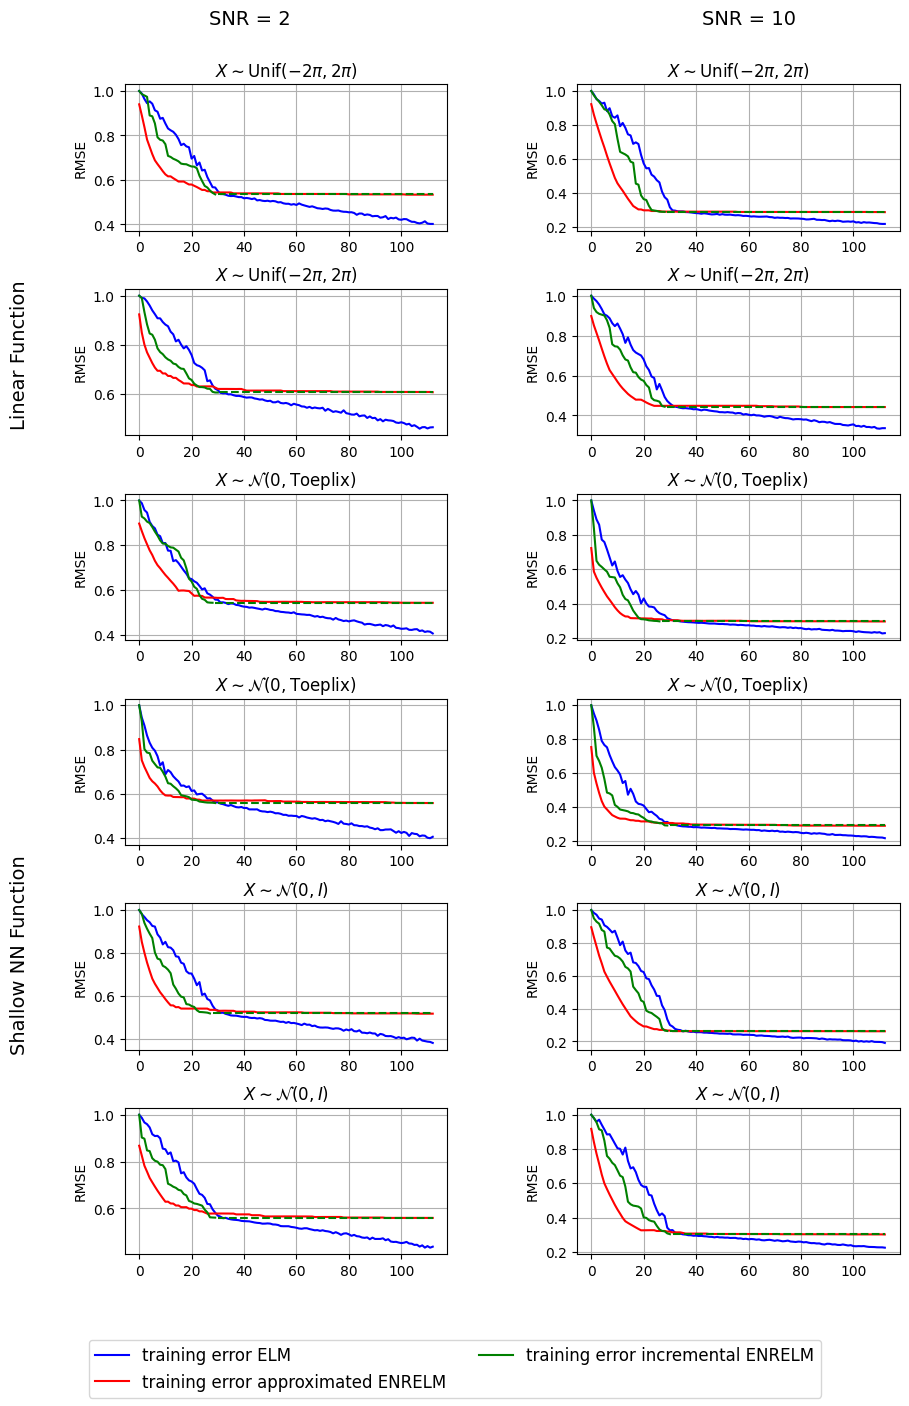

INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


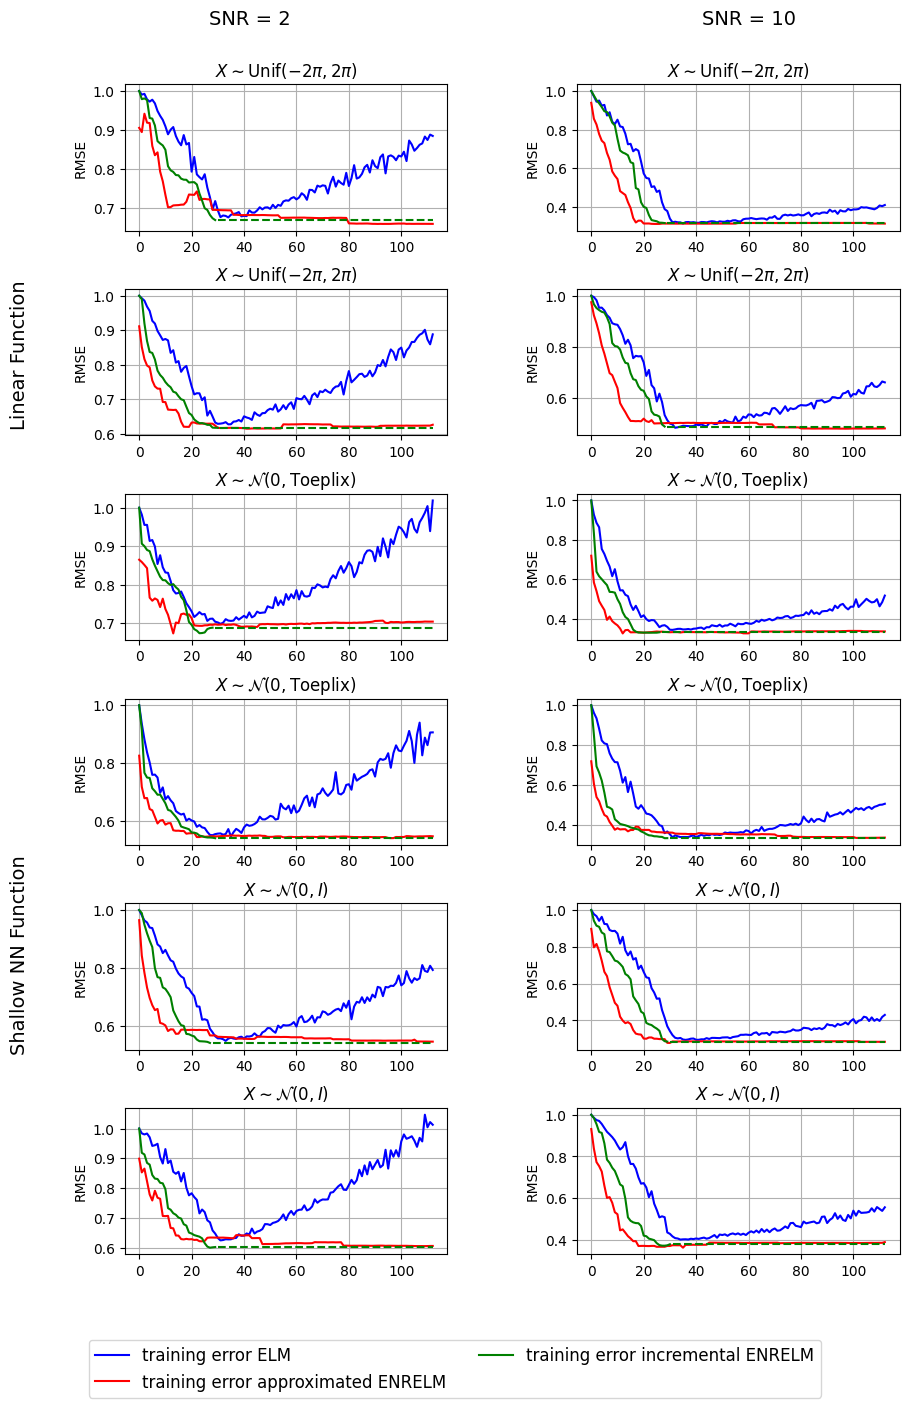

In [11]:
# Initialize figure and subplots
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig2, axes2 = plt.subplots(6, 2, figsize=(10, 15))
fig2.subplots_adjust(hspace=0.4, wspace=0.4)


# Titles for columns
column_titles = ["SNR = 2", "SNR = 10"]

# Add column titles
for i, title in enumerate(column_titles):
    fig.text(0.25 + i * 0.5, 0.92, title, ha='center', fontsize=14)
    fig2.text(0.25 + i * 0.5, 0.92, title, ha='center', fontsize=14)

fig.text(0.02, 0.7, 'Linear Function', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.02, 0.3, 'Shallow NN Function', ha='center', va='center', rotation='vertical', fontsize=14)
fig2.text(0.02, 0.7, 'Linear Function', ha='center', va='center', rotation='vertical', fontsize=14)
fig2.text(0.02, 0.3, 'Shallow NN Function', ha='center', va='center', rotation='vertical', fontsize=14)

df_times = pd.DataFrame(columns=["dataset", "total_timing_ELM", "mean_loop_timing_ELM", "timing_approximated_ENRELM", "timing_incremental_ENRELM"])

datasets_description = pd.read_csv("synthetic_datasets_description.csv", sep=';')
n0 = 30
for dataset_index in range(1, 13):
    print("Execution synthetic dataset with index: " + str(dataset_index))
    dataset_description = datasets_description[datasets_description['index'] == dataset_index]
    if dataset_description['X_distribution'].iloc[0] == "uniform":
        subplot_title = r"$X \sim \text{Unif}(-2\pi, 2\pi)$"
    elif dataset_description['X_distribution'].iloc[0] == "gaussian":
        if dataset_description['X_cov'].iloc[0] == "iid":
            subplot_title = r"$X \sim \mathcal{N}(0, I)$"
        elif dataset_description['X_cov'].iloc[0] == "toeplix":
            subplot_title = r"$X \sim \mathcal{N}(0, \text{Toeplix})$"

    filename = f'dataset_{dataset_index}.csv'
    file_path = os.path.join('datasets/synthetic', filename)
    # Load the dataset from the CSV file
    dataset = np.loadtxt(file_path, delimiter=',')

    # Split the dataset into X and y
    X = dataset[:, :-1]
    y = (dataset[:, -1]).reshape(-1,1)

    results = single_dataset_simulation(X, y)

    #save timings
    times_dictionary = {'dataset': dataset_index}
    for key,val in results.items():
        if "timing" in key:
            times_dictionary[key] = results[key]
    times = pd.DataFrame([times_dictionary])
    df_times = pd.concat([df_times, times], ignore_index=True)

    #plot figures
    ax = axes[(dataset_index-1)//2, (dataset_index-1)%2]
    ax2 = axes2[(dataset_index-1)//2, (dataset_index-1)%2]

    X_axis = np.arange(0, results['training_error_ELM'].shape[0]+1, 1)
    ax.plot(X_axis, np.concatenate([np.array([1]), results["training_error_ELM"]]), 'b-', label='training error ELM')
    ax.plot(X_axis, results['training_error_approximated_ENRELM'][0:results['training_error_ELM'].shape[0]+1], 'r-', label='training error approximated ENRELM')
    non_zeros_incremental_ENRELM_training = results['training_error_incremental_ENRELM'][results['training_error_incremental_ENRELM'] != 0]
    filled_incremental_ENRELM_training = np.ones(results['training_error_incremental_ENRELM'].shape[0] - non_zeros_incremental_ENRELM_training.shape[0]) * non_zeros_incremental_ENRELM_training[-1]
    ax.plot(X_axis[0:non_zeros_incremental_ENRELM_training.shape[0]], non_zeros_incremental_ENRELM_training, 'g-', label='training error incremental ENRELM')
    ax.plot(X_axis[non_zeros_incremental_ENRELM_training.shape[0]:], filled_incremental_ENRELM_training, 'g--')
    
    ax2.plot(X_axis, np.concatenate([np.array([1]), results['test_error_ELM']]), 'b-', label='testing error ELM')
    ax2.plot(X_axis, results['test_error_approximated_ENRELM'][0:results['test_error_ELM'].shape[0]+1], 'r-', label='testing error approximated ENRELM')
    non_zeros_incremental_ENRELM_test = results['test_error_incremental_ENRELM'][results['test_error_incremental_ENRELM'] != 0]
    filled_incremental_ENRELM_test = np.ones(results['test_error_incremental_ENRELM'].shape[0] - non_zeros_incremental_ENRELM_test.shape[0]) * non_zeros_incremental_ENRELM_test[-1]
    ax2.plot(X_axis[0:non_zeros_incremental_ENRELM_test.shape[0]], non_zeros_incremental_ENRELM_test, 'g-', label='test error incremental ENRELM')
    ax2.plot(X_axis[non_zeros_incremental_ENRELM_test.shape[0]:], filled_incremental_ENRELM_test, 'g--')

    ax.set_title(subplot_title)
    #ax.set_ylim(0,2)
    ax.set_ylabel('RMSE')
    #ax.legend(loc='upper right')
    ax.grid(True)

    ax2.set_title(subplot_title)
    #ax.set_ylim(0,2)
    ax2.set_ylabel('RMSE')
    #ax.legend(loc='upper right')
    ax2.grid(True)

df_times = df_times.sort_values("dataset", ascending = True)
print(df_times)
write_times_csv("times_synthetic_datasets_n0_" + str(n0) + ".csv", df_times)       

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
# Adjust layout to make space for the legend
fig2.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
#fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.savefig("image_training_synthetic_datasets_n0_" + str(n0) + ".eps", format="eps")
fig.savefig("image_training_synthetic_datasets_n0_" + str(n0) + ".png")

#fig2.tight_layout()
fig2.subplots_adjust(bottom=0.1)
fig2.savefig("image2_test_synthetic_datasets_n0_" + str(n0) + ".eps", format="eps")
fig2.savefig("image2_test_synthetic_datasets_n0_" + str(n0) + ".png")
fig.show()
fig2.show()

In [15]:
np.concatenate([np.array([1]), results["training_error_ELM"]])

array([1.        , 0.98539241, 0.97580671, 0.95165257, 0.94876873,
       0.93226762, 0.93115244, 0.88998451, 0.91521645, 0.87891706,
       0.87207264, 0.85043467, 0.84212686, 0.81551468, 0.79487379,
       0.7809312 , 0.75431056, 0.75447077, 0.73215435, 0.72114317,
       0.69994236, 0.68864008, 0.68288372, 0.64192476, 0.65052494,
       0.63605291, 0.59857683, 0.59329373, 0.59085456, 0.55554389,
       0.55385376, 0.537054  , 0.53726863, 0.53199288, 0.53145267,
       0.52606933, 0.52622268, 0.5244996 , 0.52291342, 0.51977783,
       0.52023847, 0.51793182, 0.51541919, 0.51731829, 0.51456557,
       0.51195723, 0.51313454, 0.5105966 , 0.50978522, 0.50580478,
       0.50699635, 0.50110766, 0.50267697, 0.50026539, 0.50049163,
       0.49758939, 0.49544548, 0.49195721, 0.48907224, 0.48947943,
       0.49025781, 0.485378  , 0.4857873 , 0.48247888, 0.48101011,
       0.47824682, 0.47632039, 0.4776839 , 0.47413948, 0.47030802,
       0.47771186, 0.46067477, 0.47232635, 0.46534818, 0.46409

In [9]:
for key, val in results.items():
    print(key)

training_error_approximated_ENRELM
test_error_approximated_ENRELM
timing_approximated_ENRELM
training_error_incremental_ENRELM
test_error_incremental_ENRELM
timing_incremental_ENRELM
training_error_ELM
test_error_ELM
total_timing_ELM
mean_loop_timing_ELM


### Code for timing only

In [6]:

# Define conditions
y_SNR_values = [2, 10]
y_functions = ["linear", "shallow"]
X_distributions = ["uniform", "gaussian"]
X_covs = ["iid", "toeplix"]
n0 = 100

for q in range(20):

    df_times = pd.DataFrame(columns=["dataset", "time_ENRELM", "time_ELM", "time_ELM_per_loop", "istances"])

    # Iterate through each combination to place in the correct subplot
    for i, y_SNR in enumerate(y_SNR_values):
        for j, y_function in enumerate(y_functions):
            for k, X_distribution in enumerate(X_distributions):
                if X_distribution == "uniform":

                    dataset_index = filter_csv("synthetic_datasets_description.csv", n0, X_distribution, y_function= y_function, y_SNR=y_SNR)

                    if dataset_index[0] == 1 or dataset_index[0] == 13:
                        X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = syntetic_dataset_simulation(dataset_index[0])
                    X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = syntetic_dataset_simulation(dataset_index[0])
                    
                    times = pd.DataFrame([{
                        "dataset": dataset_index[0],
                        "time_approximated_ENRELM": time_approximated_ENRELM,
                        "time_ENRELM": time_ENRELM,
                        "time_ELM": time_ELM,
                        "time_ELM_per_loop": time_ELM_per_loop,
                        "istances": 1
                    }])
                    df_times = pd.concat([df_times, times], ignore_index=True)



                elif X_distribution == "gaussian":
                    for l, X_cov in enumerate(X_covs):

                        dataset_index = filter_csv("synthetic_datasets_description.csv", n0, X_distribution, X_cov = X_cov, y_function= y_function, y_SNR=y_SNR)

                        X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = syntetic_dataset_simulation(dataset_index[0])
                        
                        times = pd.DataFrame([{
                            "dataset": dataset_index[0],
                            "time_approximated_ENRELM": time_approximated_ENRELM,
                            "time_ENRELM": time_ENRELM,
                            "time_ELM": time_ELM,
                            "time_ELM_per_loop": time_ELM_per_loop,
                            "istances": 1
                        }])
                        
                        df_times = pd.concat([df_times, times], ignore_index=True)
                        

    #df_times = df_times.sort_values("dataset", ascending = True)
    print(df_times)
    time.sleep(10)
    write_times_csv("times_synthetic_datasets_n0_" + str(n0) + ".csv", df_times)       

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      14.9611   8203.4220         410.171100        1
1       21      15.8495   7075.9819         353.799095        1
2       17      15.7182   7581.8359         379.091795        1
3       15      15.9254   8583.7275         429.186375        1
4       23      15.0886   7112.6174         355.630870        1
5       19      14.3869   7341.3654         367.068270        1
6       14      15.8367   8328.5490         416.427450        1
7       22      18.9600   7761.9693         388.098465        1
8       18      12.9655   6658.6694         332.933470        1
9       16      14.7098   8162.8976         408.144880        1
10      24      15.7558  10601.5535         530.077675        1
11      20      14.5132   6947.3198         347.365990        1


C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      12.9662  7977.8110         398.890550        1
1       21      14.9292  8150.1196         407.505980        1
2       17      15.9562  6594.1629         329.708145        1
3       15      14.4474  7995.6918         399.784590        1
4       23      18.8978  8140.8179         407.040895        1
5       19      12.9649  6627.8837         331.394185        1
6       14      14.9238  7929.9373         396.496865        1
7       22      14.1204  7934.1460         396.707300        1
8       18      13.9281  6844.0925         342.204625        1
9       16      15.9196  7841.7868         392.089340        1
10      24      13.9626  7858.8351         392.941755        1
11      20      14.9239  7602.9699         380.148495        1
0     14.9611
1     15.8495
2     15.7182
3     15.9254
4     15.0886
5     14.3869
6     15.8367
7     18.9600
8     12.9655
9     14.7098
10    15.7558
11    14.5132
Name: time_EN

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.9342  9075.8000         453.790000        1
1       21      13.9631  7948.4070         397.420350        1
2       17      15.0381  6670.8995         333.544975        1
3       15      48.1549  8119.8782         405.993910        1
4       23      14.9598  7926.3606         396.318030        1
5       19      14.6150  9690.1484         484.507420        1
6       14      14.0905  7250.3120         362.515600        1
7       22      15.8874  9213.0586         460.652930        1
8       18      12.9650  7785.5071         389.275355        1
9       16      13.9981  7999.2660         399.963300        1
10      24      14.9235  7265.6178         363.280890        1
11      20      13.9634  7376.6488         368.832440        1
0     13.96365
1     15.38935
2     15.83720
3     15.18640
4     16.99320
5     13.67590
6     15.38025
7     16.54020
8     13.44680
9     15.31470
10    14.85920
11    14.71855
N

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.9264  7142.1562         357.107810        1
1       21      14.9266  7794.2856         389.714280        1
2       17      14.9261  7438.2911         371.914555        1
3       15      14.9611  8108.1686         405.408430        1
4       23      14.9602  7092.3635         354.618175        1
5       19      15.9189  7510.5350         375.526750        1
6       14      13.9649  8030.0821         401.504105        1
7       22      33.9103  6954.8986         347.744930        1
8       18      13.9151  7447.8601         372.393005        1
9       16      14.9238  7967.7290         398.386450        1
10      24      15.4702  7172.7353         358.636765        1
11      20      13.9807  7561.2633         378.063165        1
0     14.287167
1     14.913933
2     15.570833
3     26.175900
4     16.315400
5     13.988933
6     14.950333
7     16.322600
8     13.286200
9     14.875833
10    14.880633
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      16.9538  10388.3359         519.416795        1
1       21      14.9599   7231.3166         361.565830        1
2       17      14.3982   7363.4346         368.171730        1
3       15      14.9654   7894.8264         394.741320        1
4       23      12.9645   6975.0211         348.751055        1
5       19      15.6285   7383.1927         369.159635        1
6       14      13.9295   8101.2336         405.061680        1
7       22      22.9419   7938.3479         396.917395        1
8       18      15.0613   6464.3810         323.219050        1
9       16      21.0867   7973.9723         398.698615        1
10      24      14.9380   7910.6735         395.533675        1
11      20      14.9599   6541.4589         327.072945        1
0     14.446975
1     14.917100
2     15.409650
3     23.372200
4     15.976600
5     14.471425
6     14.703975
7     20.719525
8     13.443425
9     14.887825
10    15

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      14.7473   7773.5451         388.677255        1
1       21      16.5735   7134.2585         356.712925        1
2       17      14.4607   7210.2598         360.512990        1
3       15      15.0618   8008.3983         400.419915        1
4       23      15.0799   7050.5979         352.529895        1
5       19      14.1769   7322.7913         366.139565        1
6       14      14.9600   7828.8393         391.441965        1
7       22      13.9289   7251.6264         362.581320        1
8       18      15.9575   7381.6871         369.084355        1
9       16      15.8248  10008.0108         500.400540        1
10      24      15.3449   7824.3937         391.219685        1
11      20      13.9631   6435.4833         321.774165        1
0     14.94834
1     14.92566
2     15.20736
3     21.69084
4     15.37418
5     14.70284
6     14.54908
7     21.16400
8     13.76700
9     16.12760
10    15.01002
11 

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      13.9286  7793.5927         389.679635        1
1       21      15.9184  7084.3693         354.218465        1
2       17      13.9635  7296.7332         364.836660        1
3       15      13.9278  7907.9889         395.399445        1
4       23      14.9273  6911.3881         345.569405        1
5       19      14.9604  7102.4571         355.122855        1
6       14      14.9253  7960.4312         398.021560        1
7       22      15.5357  6998.3214         349.916070        1
8       18      15.1226  7167.9277         358.396385        1
9       16      15.7487  7994.2476         399.712380        1
10      24      14.9465  6964.5656         348.228280        1
11      20      13.9293  7239.9550         361.997750        1
0     14.914833
1     15.200300
2     15.082917
3     20.586000
4     15.325133
5     14.615183
6     14.617567
7     19.958150
8     14.132083
9     16.077133
10    15.065833
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.9592  8052.1449         402.607245        1
1       21      15.3817  7091.8239         354.591195        1
2       17      15.1452  7197.9156         359.895780        1
3       15      15.9568  7951.7704         397.588520        1
4       23      14.9267  7101.9702         355.098510        1
5       19      49.8677  9570.8487         478.542435        1
6       14      16.7602  8074.0797         403.703985        1
7       22      14.9230  7715.9566         385.797830        1
8       18      12.9650  6465.7586         323.287930        1
9       16      14.9428  7764.8390         388.241950        1
10      24      15.7143  7755.5643         387.778215        1
11      20      13.9622  6444.0951         322.204755        1
0     14.773943
1     15.302886
2     14.923000
3     19.634829
4     15.268300
5     14.664500
6     14.661529
7     19.326371
8     14.273586
9     16.030214
10    15.048786
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      13.9625  8026.5802         401.329010        1
1       21      13.9633  7036.9042         351.845210        1
2       17      13.9633  7300.3967         365.019835        1
3       15      14.7878  8242.4590         412.122950        1
4       23      14.9266  7077.1115         353.855575        1
5       19      13.9626  7035.1818         351.759090        1
6       14      14.9241  7878.3904         393.919520        1
7       22      14.4806  6967.2588         348.362940        1
8       18      14.9235  7170.1828         358.509140        1
9       16      14.9589  7823.2758         391.163790        1
10      24      14.9244  6938.4027         346.920135        1
11      20      14.3114  7336.2742         366.813710        1
0     14.797100
1     15.312738
2     14.950775
3     19.175075
4     15.225600
5     19.064900
6     14.923862
7     18.775950
8     14.110012
9     15.894288
10    15.131975
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      14.8214  10187.8912         509.394560        1
1       21      13.9625   7103.0801         355.154005        1
2       17      14.0053   7412.0292         370.601460        1
3       15      13.9623   8109.9646         405.498230        1
4       23      14.9607   6925.4555         346.272775        1
5       19      15.9258   7279.8207         363.991035        1
6       14      15.8488   7856.2894         392.814470        1
7       22      17.9159   7305.9893         365.299465        1
8       18      15.3045   7375.8374         368.791870        1
9       16      12.9654   7766.8630         388.343150        1
10      24      15.8026   6950.4579         347.522895        1
11      20      13.9631   7133.3243         356.666215        1
0     14.704367
1     15.162800
2     14.841056
3     18.687600
4     15.192378
5     18.497978
6     14.923889
7     18.298689
8     14.200400
9     15.790356
10    15

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      13.5398   7925.1205         396.256025        1
1       21      13.9635   7010.7984         350.539920        1
2       17      33.3731   7237.6789         361.883945        1
3       15      13.9631   7982.3946         399.119730        1
4       23      15.5597   7002.0484         350.102420        1
5       19      13.9287   7226.0880         361.304400        1
6       14      13.9209   8042.4589         402.122945        1
7       22      14.5495   7511.4293         375.571465        1
8       18      20.9569   7144.1853         357.209265        1
9       16      13.9643   7762.5917         388.129585        1
10      24      15.5832  10849.7441         542.487205        1
11      20      19.9106   6759.9519         337.997595        1
0     14.71607
1     15.04277
2     14.75748
3     18.21507
4     15.16921
5     18.24076
6     15.01638
7     18.26041
8     14.31081
9     15.50786
10    15.17828
11 

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.8113  7965.9932         398.299660        1
1       21      14.9274  7033.9788         351.698940        1
2       17      18.9235  7170.4241         358.521205        1
3       15      14.9584  7882.0332         394.101660        1
4       23      16.2458  6967.0407         348.352035        1
5       19      19.9227  7319.4867         365.974335        1
6       14      14.9261  7802.7987         390.139935        1
7       22      14.9610  6963.2611         348.163055        1
8       18      14.9347  7508.5979         375.429895        1
9       16      13.9631  7825.0165         391.250825        1
10      24      15.9315  7565.9112         378.295560        1
11      20      15.9580  6493.4911         324.674555        1
0     14.609136
1     14.944655
2     16.449809
3     17.828527
4     15.204709
5     17.848755
6     14.916791
7     17.923055
8     14.915000
9     15.367536
10    15.215091
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      15.9210  7916.0343         395.801715        1
1       21      15.5033  7058.3317         352.916585        1
2       17      13.9627  7465.5366         373.276830        1
3       15      14.4976  7854.6856         392.734280        1
4       23      13.9633  7093.2617         354.663085        1
5       19      14.9591  9361.8210         468.091050        1
6       14      15.4744  8862.8214         443.141070        1
7       22      16.9171  8417.5087         420.875435        1
8       18      14.9235  6570.2746         328.513730        1
9       16      14.4064  8082.0497         404.102485        1
10      24      13.9637  8076.2402         403.812010        1
11      20      14.9279  6491.9412         324.597060        1
0     14.625983
1     14.943217
2     16.655950
3     17.589350
4     15.291467
5     18.021583
6     14.917567
7     17.676217
8     14.916642
9     15.250500
10    15.274792
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      13.9627  7909.4636         395.473180        1
1       21      14.3270  7907.6356         395.381780        1
2       17      13.9625  6507.7400         325.387000        1
3       15      14.9207  8139.7809         406.989045        1
4       23      15.9577  7758.3932         387.919660        1
5       19      14.8867  6505.5107         325.275535        1
6       14      15.1022  7785.2901         389.264505        1
7       22      15.9252  7872.1471         393.607355        1
8       18      13.9628  6478.7007         323.935035        1
9       16      13.9626  7978.1801         398.909005        1
10      24      14.9278  7927.2338         396.361690        1
11      20      14.9238  6590.3960         329.519800        1
0     14.725600
1     14.986300
2     16.448777
3     17.351523
4     15.189300
5     17.786008
6     14.960400
7     17.617823
8     14.917169
9     15.185569
10    15.173938
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0       13      12.9643  10334.9772         516.748860        1
1       21      16.4278   7921.2464         396.062320        1
2       17      14.7328   6594.1568         329.707840        1
3       15      15.1470   8105.2704         405.263520        1
4       23      13.9632   7835.4426         391.772130        1
5       19      13.9022   6684.3679         334.218395        1
6       14      15.0936   8000.4399         400.021995        1
7       22      14.9603   7886.9063         394.345315        1
8       18      15.9246   6638.7909         331.939545        1
9       16      15.1320   7723.9198         386.195990        1
10      24      14.9325   7879.7901         393.989505        1
11      20      14.9596   6472.5492         323.627460        1
0     14.671107
1     14.939207
2     16.271186
3     17.177893
4     15.244186
5     17.578914
6     14.970529
7     17.496921
8     14.849000
9     15.098214
10    15

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.9342  8085.1059         404.255295        1
1       21      14.9295  7901.6385         395.081925        1
2       17      13.9633  6455.6558         322.782790        1
3       15      15.1996  8054.4894         402.724470        1
4       23      14.9611  7903.8785         395.193925        1
5       19      13.9285  6835.1164         341.755820        1
6       14      14.9239  7851.9705         392.598525        1
7       22      14.9346  7605.0330         380.251650        1
8       18      14.9260  6506.6510         325.332550        1
9       16      14.9692  9759.1876         487.959380        1
10      24      13.9639  7841.5448         392.077240        1
11      20      15.9237  6502.8085         325.140425        1
0     14.557320
1     15.038447
2     16.168627
3     17.042500
4     15.158787
5     17.333800
6     14.978733
7     17.327813
8     14.920707
9     15.100467
10    15.141433
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      13.9621  8034.0004         401.700020        1
1       21      15.2194  7756.3842         387.819210        1
2       17      13.9622  6512.2228         325.611140        1
3       15      15.9212  7962.6262         398.131310        1
4       23      13.9633  7624.9603         381.248015        1
5       19      13.9625  6596.3835         329.819175        1
6       14      15.2602  7878.7699         393.938495        1
7       22      14.9827  7908.0707         395.403535        1
8       18      40.8571  6463.3017         323.165085        1
9       16      14.9606  8060.1159         403.005795        1
10      24      14.9608  7633.1072         381.655360        1
11      20      16.7748  6462.5524         323.127620        1
0     14.580875
1     15.031638
2     16.030794
3     16.927319
4     15.146431
5     17.120969
6     14.975306
7     17.178238
8     14.921037
9     15.092263
10    15.067837
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.6333  7904.0229         395.201145        1
1       21      14.9281  6991.8902         349.594510        1
2       17      15.8402  7264.9179         363.245895        1
3       15      18.9487  7897.8633         394.893165        1
4       23      13.9625  6936.0435         346.802175        1
5       19      13.9635  9673.3531         483.667655        1
6       14      15.1379  7933.3349         396.666745        1
7       22      14.9585  7822.2734         391.113670        1
8       18      14.9609  6443.9100         322.195500        1
9       16      13.9628  8080.3907         404.019535        1
10      24      13.9295  7874.1923         393.709615        1
11      20      14.9589  6517.6197         325.880985        1
0     14.544476
1     15.042682
2     15.909112
3     16.868135
4     15.076835
5     16.935176
6     14.992065
7     17.049088
8     16.446688
9     15.084518
10    15.061541
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      15.7787  7845.0144         392.250720        1
1       21      15.1305  7391.5199         369.575995        1
2       17      14.9905  7322.4398         366.121990        1
3       15      16.9552  8112.9326         405.646630        1
4       23      15.1505  7656.3266         382.816330        1
5       19      13.9622  6547.0579         327.352895        1
6       14      31.8978  7758.1535         387.907675        1
7       22      14.9600  7627.8805         381.394025        1
8       18      12.9668  6569.8108         328.490540        1
9       16      14.9259  8229.3032         411.465160        1
10      24      15.9558  7773.2295         388.661475        1
11      20      13.9602  6402.9223         320.146115        1
0     14.549411
1     15.036317
2     15.905283
3     16.983722
4     15.014928
5     16.770083
6     15.000167
7     16.932944
8     16.364144
9     15.022200
10    14.998650
11   

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\1451145861.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


   dataset  time_ENRELM   time_ELM  time_ELM_per_loop istances
0       13      14.9269  9976.2367         498.811835        1
1       21      14.9606  7870.5554         393.527770        1
2       17      13.9629  6755.2541         337.762705        1
3       15      14.9265  8102.8205         405.141025        1
4       23      13.9630  7634.0633         381.703165        1
5       19      14.9629  6494.0474         324.702370        1
6       14      14.9605  8179.3719         408.968595        1
7       22      14.9586  7808.8698         390.443490        1
8       18      44.2380  6509.1268         325.456340        1
9       16      13.9631  7696.5064         384.825320        1
10      24      13.9625  7595.8718         379.793590        1
11      20      13.4358  6492.7087         324.635435        1
0     14.614111
1     15.041274
2     15.857137
3     16.982221
4     15.022063
5     16.622300
6     15.889516
7     16.829105
8     16.185337
9     15.017132
10    15.049026
11   

# Experiments on real datasets

Abalone


C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\2169040977.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  total_timing_ELM  mean_loop_timing_ELM  \
0             Abalone      5.367339e+05          26836.695585   
1            Auto MPG      7.533850e+03            376.692505   
2                Bank      6.144719e+05          30723.593120   
3  California Housing      1.491235e+06          74561.752015   
4      Delta Ailerons      2.022044e+05          10110.222355   
5            LA Ozone      5.334823e+03            266.741175   
6         Machine CPU      1.516756e+03             75.837780   
7     Prostate Cancer      2.058279e+02             10.291395   
8               Servo      7.298363e+02             36.491815   

   timing_approximated_ENRELM  timing_incremental_ENRELM  
0                   8664.6449               1.257269e+04  
1                     24.5677               2.136200e+02  
2                  50760.4752              

C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\2169040977.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\fabia\AppData\Local\Temp\ipykernel_15776\2169040977.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


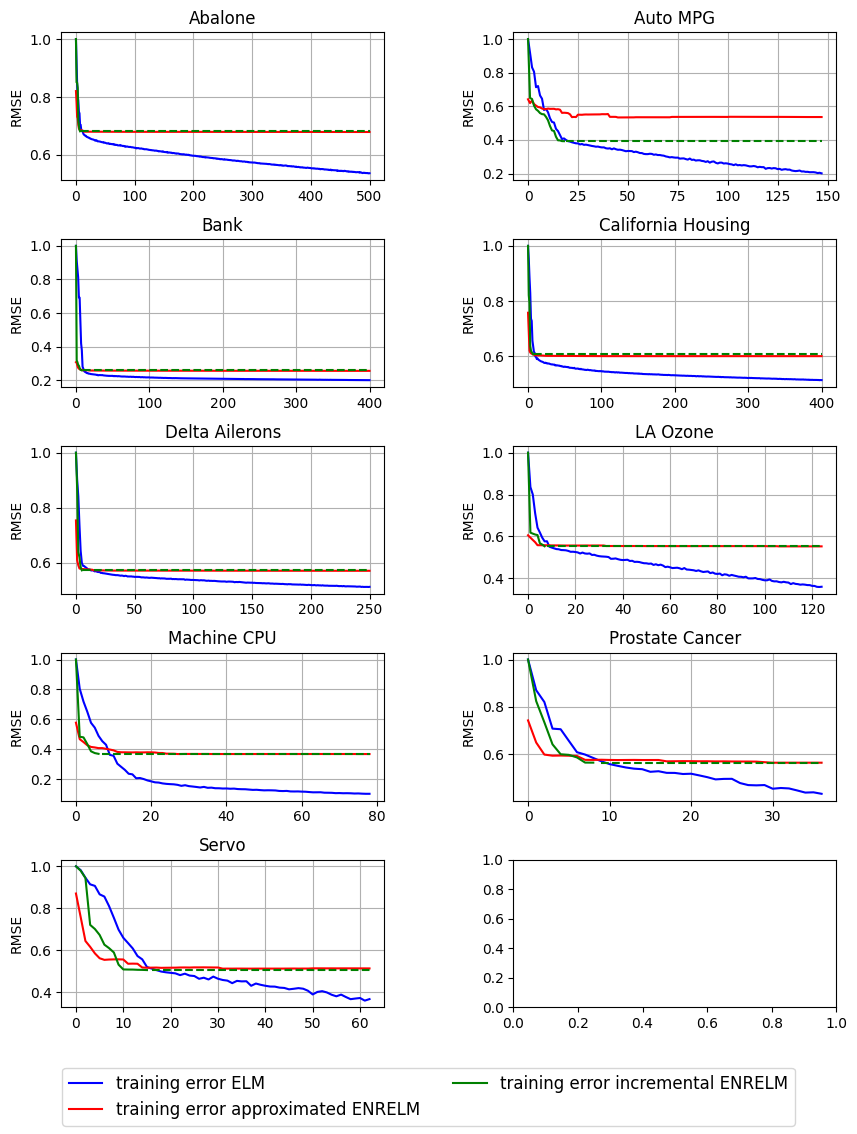

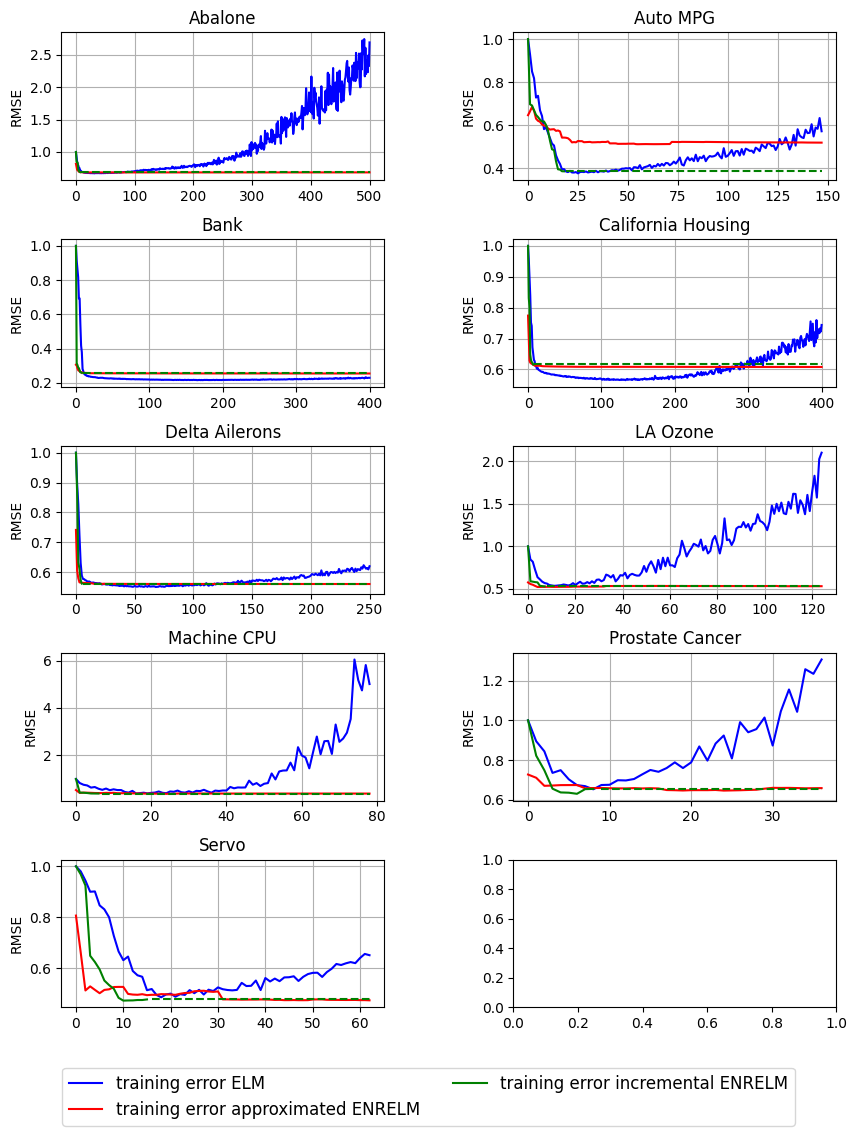

In [14]:
# Initialize figure and subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 12.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig2, axes2 = plt.subplots(5, 2, figsize=(10, 12.5))
fig2.subplots_adjust(hspace=0.4, wspace=0.4)

loaders = {
    1: ("Abalone", dataloader.load_abalone),
    2: ("Auto MPG", dataloader.load_auto_mpg),
    3: ("Bank", dataloader.load_bank),
    4: ("California Housing", dataloader.load_california_housing),
    5: ("Delta Ailerons", dataloader.load_delta_ailerons),
    6: ("LA Ozone", dataloader.load_LAozone),
    7: ("Machine CPU", dataloader.load_machine_cpu),
    8: ("Prostate Cancer", dataloader.load_prostate),
    9: ("Servo", dataloader.load_servo)
}

df_times = pd.DataFrame(columns=["dataset", "total_timing_ELM", "mean_loop_timing_ELM", "timing_approximated_ENRELM", "timing_incremental_ENRELM"])
dataset_index = 0
for key, value in loaders.items():
    dataset_index+=1
    name = value[0]
    loader = value[1]
    generator = datagenerator.LoaderDataGenerator(name, loader)
    res = generator.generate()
    print(res['name'])
    X = res['data'][0]
    y = res['data'][1]


    results = single_dataset_simulation(X, y)

    #save timings
    times_dictionary = {'dataset': name}
    for key,val in results.items():
        if "timing" in key:
            times_dictionary[key] = results[key]
    times = pd.DataFrame([times_dictionary])
    df_times = pd.concat([df_times, times], ignore_index=True)

    #plot figures
    ax = axes[(dataset_index-1)//2, (dataset_index-1)%2]
    ax2 = axes2[(dataset_index-1)//2, (dataset_index-1)%2]

    X_axis = np.arange(0, results['training_error_ELM'].shape[0]+1, 1)
    ax.plot(X_axis, np.concatenate([np.array([1]), results["training_error_ELM"]]), 'b-', label='training error ELM')
    ax.plot(X_axis, results['training_error_approximated_ENRELM'][0:results['training_error_ELM'].shape[0]+1], 'r-', label='training error approximated ENRELM')
    non_zeros_incremental_ENRELM_training = results['training_error_incremental_ENRELM'][results['training_error_incremental_ENRELM'] != 0]
    filled_incremental_ENRELM_training = np.ones(results['training_error_incremental_ENRELM'].shape[0] - non_zeros_incremental_ENRELM_training.shape[0]) * non_zeros_incremental_ENRELM_training[-1]
    ax.plot(X_axis[0:non_zeros_incremental_ENRELM_training.shape[0]], non_zeros_incremental_ENRELM_training, 'g-', label='training error incremental ENRELM')
    ax.plot(X_axis[non_zeros_incremental_ENRELM_training.shape[0]:], filled_incremental_ENRELM_training, 'g--')
    
    ax2.plot(X_axis, np.concatenate([np.array([1]), results['test_error_ELM']]), 'b-', label='testing error ELM')
    ax2.plot(X_axis, results['test_error_approximated_ENRELM'][0:results['test_error_ELM'].shape[0]+1], 'r-', label='testing error approximated ENRELM')
    non_zeros_incremental_ENRELM_test = results['test_error_incremental_ENRELM'][results['test_error_incremental_ENRELM'] != 0]
    filled_incremental_ENRELM_test = np.ones(results['test_error_incremental_ENRELM'].shape[0] - non_zeros_incremental_ENRELM_test.shape[0]) * non_zeros_incremental_ENRELM_test[-1]
    ax2.plot(X_axis[0:non_zeros_incremental_ENRELM_test.shape[0]], non_zeros_incremental_ENRELM_test, 'g-', label='test error incremental ENRELM')
    ax2.plot(X_axis[non_zeros_incremental_ENRELM_test.shape[0]:], filled_incremental_ENRELM_test, 'g--')

    ax.set_title(name)
    #ax.set_ylim(0,2)
    ax.set_ylabel('RMSE')
    #ax.legend(loc='upper right')
    ax.grid(True)

    ax2.set_title(name)
    #ax.set_ylim(0,2)
    ax2.set_ylabel('RMSE')
    #ax.legend(loc='upper right')
    ax2.grid(True)

df_times = df_times.sort_values("dataset", ascending = True)
print(df_times)
write_times_csv("times_real_datasets" + str(n0) + ".csv", df_times)       

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
# Adjust layout to make space for the legend
fig2.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
#fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.savefig("image_training_real_datasets.eps", format="eps")
fig.savefig("image_training_real_datasets.png")

#fig2.tight_layout()
fig2.subplots_adjust(bottom=0.1)
fig2.savefig("image2_test_real_datasets.eps", format="eps")
fig2.savefig("image2_test_real_datasets.png")
fig.show()
fig2.show()

### Code for timing only


In [21]:

# Define conditions
loaders = {
    1: ("Abalone", dataloader.load_abalone),
    2: ("Auto MPG", dataloader.load_auto_mpg),
    3: ("Bank", dataloader.load_bank),
    4: ("California Housing", dataloader.load_california_housing),
    5: ("Delta Ailerons", dataloader.load_delta_ailerons),
    6: ("LA Ozone", dataloader.load_LAozone),
    7: ("Machine CPU", dataloader.load_machine_cpu),
    8: ("Prostate Cancer", dataloader.load_prostate),
    9: ("Servo", dataloader.load_servo)
    }

for q in range(8):

    df_times = pd.DataFrame(columns=["dataset", "time_ENRELM", "time_ELM", "time_ELM_per_loop", "istances"])


    for key, value in loaders.items():
                    name = value[0]
                    loader = value[1]
                    generator = datagenerator.LoaderDataGenerator(name, loader)
                    res = generator.generate()
                    print(res['name'])
                    X = res['data'][0]
                    y = res['data'][1]

                    if name == "Abalone":
                        X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = single_dataset_simulation(X,y)
                    X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = single_dataset_simulation(X,y)
                    
                    times = pd.DataFrame([{
                        "dataset": name,
                        "time_approximated_ENRELM": time_approximated_ENRELM,
                        "time_ENRELM": time_ENRELM,
                        "time_ELM": time_ELM,
                        "time_ELM_per_loop": time_ELM_per_loop,
                        "istances": 1
                    }])
                    df_times = pd.concat([df_times, times], ignore_index=True)
                    


    print(df_times)
    time.sleep(10)
    write_times_csv("times_real_datasets.csv", df_times)       

Abalone


C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    6861.8854     49.1069           2.455345        1
1            Auto MPG      23.9619    223.1308          11.156540        1
2                Bank   47493.9492  10921.0370         546.051850        1
3  California Housing  662189.3839    445.8084          22.290420        1
4      Delta Ailerons   29017.5753    101.7284           5.086420        1
5            LA Ozone      15.6512     82.3487           4.117435        1
6         Machine CPU       6.9810     12.8063           0.640315        1
7     Prostate Cancer       2.9920     37.7465           1.887325        1
8               Servo       5.9915    581.5740          29.078700        1
Abalone


C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    6863.5704     55.8500           2.792500        1
1            Auto MPG      24.9333    239.3596          11.967980        1
2                Bank   46540.8202  10500.9796         525.048980        1
3  California Housing  653365.9929    464.0309          23.201545        1
4      Delta Ailerons   29577.0960    100.7330           5.036650        1
5            LA Ozone      17.9510     81.2085           4.060425        1
6         Machine CPU       7.2305     11.9679           0.598395        1
7     Prostate Cancer       3.9901     34.3948           1.719740        1
8               Servo       5.8482    596.6727          29.833635        1
0      6861.8854
1        23.9619
2     47493.9492
3    662189.3839
4     29017.5753
5        15.6512
6         6.9810
7 

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    7071.4231     50.8641           2.543205        1
1            Auto MPG      22.0059    211.4346          10.571730        1
2                Bank   47478.2584  10839.1392         541.956960        1
3  California Housing  659797.3286    470.7411          23.537055        1
4      Delta Ailerons   29615.8896    106.7147           5.335735        1
5            LA Ozone      15.1333     78.8120           3.940600        1
6         Machine CPU       6.7117     11.9673           0.598365        1
7     Prostate Cancer       3.1090     35.9044           1.795220        1
8               Servo       5.9414    592.9290          29.646450        1
0      6862.72790
1        24.44760
2     47017.38470
3    657777.68840
4     29297.33565
5        16.80110
6         7.1

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    6812.7744     48.7660           2.438300        1
1            Auto MPG      21.9408    215.6028          10.780140        1
2                Bank   47656.9119  11078.5967         553.929835        1
3  California Housing  659369.3371    480.3436          24.017180        1
4      Delta Ailerons   29735.4188    126.6609           6.333045        1
5            LA Ozone      13.9633     81.6766           4.083830        1
6         Machine CPU       6.8894     13.8042           0.690210        1
7     Prostate Cancer       2.3619     34.9082           1.745410        1
8               Servo       5.9517    600.3928          30.019640        1
0      6932.292967
1        23.633700
2     47171.009267
3    658450.901800
4     29403.520300
5        16.245167
6      

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    7680.4328     53.8233           2.691165        1
1            Auto MPG      21.9418    241.1819          12.059095        1
2                Bank   47535.7224  11013.6487         550.682435        1
3  California Housing  661134.3375    451.1372          22.556860        1
4      Delta Ailerons   30458.0568    107.7117           5.385585        1
5            LA Ozone      14.1726     86.3642           4.318210        1
6         Machine CPU       7.9786     16.9542           0.847710        1
7     Prostate Cancer       2.9916     49.8673           2.493365        1
8               Servo       5.4792    757.2597          37.862985        1
0      6902.413325
1        23.210475
2     47292.484925
3    658680.510625
4     29486.494925
5        15.674700
6      

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    7207.5810     53.8170           2.690850        1
1            Auto MPG      24.7201    239.3769          11.968845        1
2                Bank   48641.8132  10776.9038         538.845190        1
3  California Housing  649464.7925    470.7406          23.537030        1
4      Delta Ailerons   29237.2036    100.1596           5.007980        1
5            LA Ozone      14.9622     87.0036           4.350180        1
6         Machine CPU       6.7434     12.3793           0.618965        1
7     Prostate Cancer       1.7999     34.9065           1.745325        1
8               Servo       4.6703    615.9260          30.796300        1
0      7058.01722
1        22.95674
2     47341.13242
3    659171.27600
4     29680.80730
5        15.37428
6         7.1

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    6818.6902     47.1643           2.358215        1
1            Auto MPG      21.9076    222.0269          11.101345        1
2                Bank   46903.2149  10805.6018         540.280090        1
3  California Housing  656086.8649    756.9736          37.848680        1
4      Delta Ailerons   30410.3274     97.0406           4.852030        1
5            LA Ozone      15.9598     83.7770           4.188850        1
6         Machine CPU       4.9865     11.9682           0.598410        1
7     Prostate Cancer       1.9806     35.1452           1.757260        1
8               Servo       5.2065    593.8127          29.690635        1
0      7082.944517
1        23.250633
2     47557.912550
3    657553.528750
4     29606.873350
5        15.305600
6      

C:\Users\fabia\AppData\Local\Temp\ipykernel_5488\579203030.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_times = pd.concat([df_times, times], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Auto MPG
Bank
California Housing
Delta Ailerons
LA Ozone
Machine CPU
Prostate Cancer
Servo
              dataset  time_ENRELM    time_ELM  time_ELM_per_loop istances
0             Abalone    6983.3981     54.4605           2.723025        1
1            Auto MPG      23.0146    232.4605          11.623025        1
2                Bank   46907.9355  10738.2456         536.912280        1
3  California Housing  652280.0002    468.7453          23.437265        1
4      Delta Ailerons   29070.6128    102.1839           5.109195        1
5            LA Ozone      16.0811     77.7962           3.889810        1
6         Machine CPU       5.3066     12.9651           0.648255        1
7     Prostate Cancer       2.4504     34.9068           1.745340        1
8               Servo       6.2956    576.0314          28.801570        1
0      7045.193900
1        23.058771
2     47464.384314
3    657344.005343
4     29721.652500
5        15.399057
6      

In [17]:
t = "Abalone;8104.5149;398883.637;19944.18185\nAuto MPG;23.9356;7807.561;390.37805\nBank;49046.2485;440475.2804;22023.76402\nDelta Ailerons;29961.7806;136989.3605;6849.468025\nLA Ozone;16.9537;4161.0684;208.05342\nMachine CPU;6.6234;1354.0611;67.703055\nProstate Cancer;2.9974;187.6047;9.380235\nServo;6.3463;801.8171;40.090855"
d_ = t.split("\n")
for d in d_:
    p = d.split(";")
    print(p[0] + " & " + str(round(float(p[1]), 2)) + " ms & " + str(round(float(p[2])/1000.0, 3)) + " s & " + str(round(float(p[3]), 2)) + " ms \\\\")

Abalone & 8104.51 ms & 398.884 s & 19944.18 ms \\
Auto MPG & 23.94 ms & 7.808 s & 390.38 ms \\
Bank & 49046.25 ms & 440.475 s & 22023.76 ms \\
Delta Ailerons & 29961.78 ms & 136.989 s & 6849.47 ms \\
LA Ozone & 16.95 ms & 4.161 s & 208.05 ms \\
Machine CPU & 6.62 ms & 1.354 s & 67.7 ms \\
Prostate Cancer & 3.0 ms & 0.188 s & 9.38 ms \\
Servo & 6.35 ms & 0.802 s & 40.09 ms \\


# temp

Abalone
(1, 1)
(2, 1)


ValueError: could not broadcast input array from shape (2,1) into shape (2,)

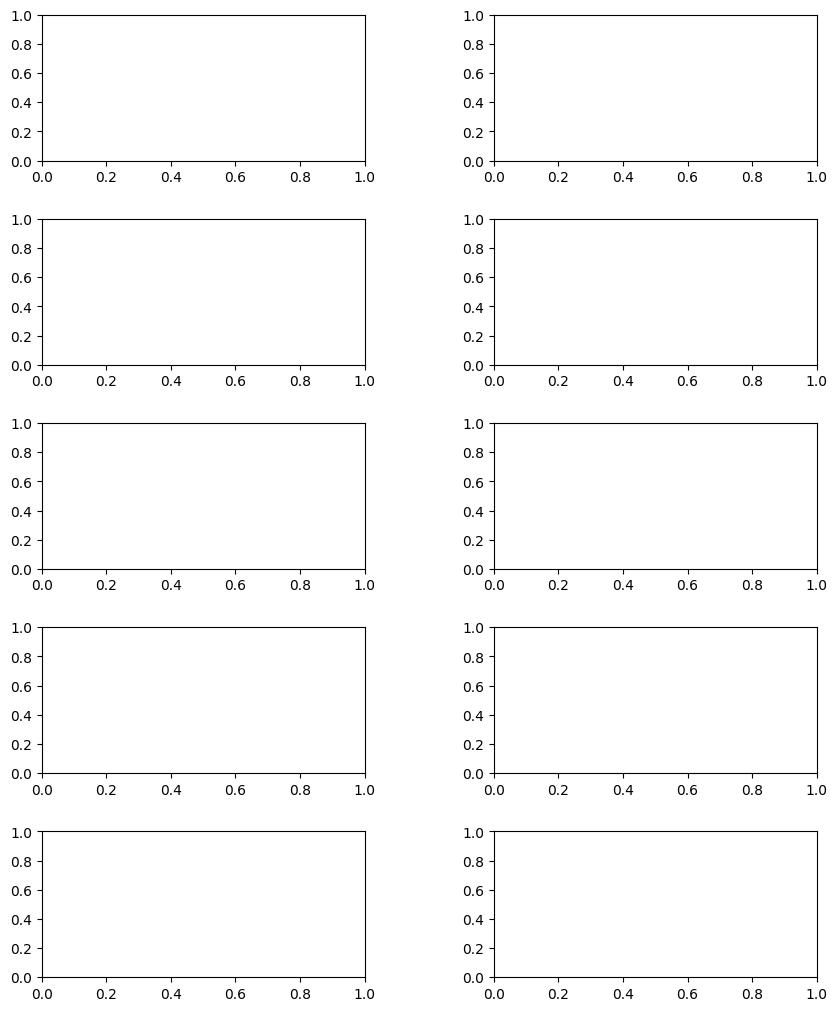

In [5]:
# Initialize figure and subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 12.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

loaders = {
    1: ("Abalone", dataloader.load_abalone),
    2: ("Auto MPG", dataloader.load_auto_mpg),
    3: ("Bank", dataloader.load_bank),
#    4: ("California Housing", dataloader.load_california_housing),
    5: ("Delta Ailerons", dataloader.load_delta_ailerons),
    6: ("LA Ozone", dataloader.load_LAozone),
    7: ("Machine CPU", dataloader.load_machine_cpu),
    8: ("Prostate Cancer", dataloader.load_prostate),
    9: ("Servo", dataloader.load_servo)
}

df_times = pd.DataFrame(columns=["dataset", "time_ENRELM", "time_ELM", "time_ELM_per_loop"])

for key, value in loaders.items():
                ax = axes[(key-1)//2, (key-1)%2]
                name = value[0]
                loader = value[1]
                generator = datagenerator.LoaderDataGenerator(name, loader)
                res = generator.generate()
                print(res['name'])
                X = res['data'][0]
                y = res['data'][1]

                X_axis, train_err_ELM, train_err_ENRELM, train_err_approximated_ENRELM,test_err_ELM, test_err_ENRELM, test_err_approximated_ENRELM, time_ENRELM, time_approximated_ENRELM, time_ELM, time_ELM_per_loop = single_dataset_simulation(X,y)

                times = pd.DataFrame([{
                    "dataset": name,
                    "time_ENRELM": time_ENRELM,
                    "time_ELM": time_ELM,
                    "time_ELM_per_loop": time_ELM_per_loop
                }])
                df_times = pd.concat([df_times, times], ignore_index=True)
                
                ax.plot(X_axis, train_err_ELM, 'b--', label='training error ELM')
                ax.plot(X_axis, train_err_approximated_ENRELM, 'r--', label='training error approximated ENRELM')
                ax.plot(X_axis, train_err_ENRELM, 'y--', label='training error ENRELM')
                ax.plot(X_axis, test_err_ELM, 'b-', label='testing error ELM')
                ax.plot(X_axis, test_err_approximated_ENRELM, 'r-', label='testing error approximated ENRELM')
                ax.plot(X_axis, test_err_ENRELM, 'y-', label='testing error ENRELM')
                ax.set_title(name)
                ax.set_ylim(0,2)
                ax.set_ylabel('RMSE')
                #ax.legend(loc='upper right')
                ax.grid(True)

df_times.to_csv("times_real_datasets.csv", sep=";", index=False)
            
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.1)
# Show plot
#plt.savefig("image_real_datasets.eps", format="eps")
#plt.savefig("image_real_datasets.png")
plt.show()